---

### **Zadanie práce:**
- Vytvoriť MLP, kde bude riešiť:
- Data analysis ,Data preprocessing and normalization, Data split, Configuration, Experiment tracking, Experiments - meaningful based on the results of previous experiments, Including improvement techniques (e.g. Dropout, Normalization layers, Skip Connections, Bottleneck Layers, …), Hyperparameter search (grid/random) / sweep, Results and, evaluation metrics, Clear code, Markdown documentation and comments, Final presentation of projects, Effort on consultations

Druh MLP: Binary classicifacion <br>
Dataset: https://api.openml.org/d/40536

Vytvorili: Alex Duchoň, Kriśtof Kmeť, David Vach
> experimenty sme trackovali pomocou *wandb*

---

## Importy a načítanie dát

In [27]:
# 1. Základná manipulácia s dátami a numerika
import pandas as pd
import numpy as np  

# 2. Vizualizácia dát
import matplotlib.pyplot as plt  
import seaborn as sns          

# 3. Štandardné Python pomocné knižnice
import math          
import re               
import time              
import warnings           
from collections import Counter, defaultdict 

# 4. Scikit-learn: Príprava dát (Preprocessing) a Imputácia
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from category_encoders import TargetEncoder 

# 5. Scikit-learn: Výber príznakov (Feature Selection)
from sklearn.feature_selection import (VarianceThreshold,mutual_info_classif,SelectKBest,chi2,f_classif,RFE,SelectFromModel)

# 6. Scikit-learn: Modely, Pipeline a Nástroje
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline                 
from sklearn.compose import ColumnTransformer          


# 7. Scikit-learn: Evaluácia modelov a Rozdelenie dát
from sklearn.model_selection import (train_test_split,GridSearchCV,StratifiedKFold)
from sklearn.metrics import (accuracy_score,f1_score,log_loss,confusion_matrix,classification_report)


# 8. Deep Learning (PyTorch)
import torch
import torch.nn as nn 

# 9. Skorch (Spojenie PyTorch a Scikit-learn)
from skorch import NeuralNetBinaryClassifier
from skorch.dataset import Dataset, ValidSplit
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, EpochScoring

# 10. Experiment Tracking (Weights & Biases)
import wandb
from skorch.callbacks import WandbLogger 
warnings.filterwarnings("ignore")

In [28]:
df=pd.read_csv("speeddating.csv", sep=",")
df.columns

Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age',
       'race', 'race_o', 'samerace',
       ...
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'like',
       'guess_prob_liked', 'd_like', 'd_guess_prob_liked', 'met', 'decision',
       'decision_o', 'match'],
      dtype='object', length=123)

---

## EDA

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_null,8378.0,0.874910,0.330840,0.0,1.0,1.0,1.0,1.0
wave,8378.0,11.350919,5.995903,1.0,7.0,11.0,15.0,21.0
d_age,8378.0,4.185605,4.596171,0.0,1.0,3.0,5.0,37.0
samerace,8378.0,0.395799,0.489051,0.0,0.0,0.0,1.0,1.0
decision,8378.0,0.419909,0.493573,0.0,0.0,0.0,1.0,1.0
decision_o,8378.0,0.419551,0.493515,0.0,0.0,0.0,1.0,1.0
match,8378.0,0.164717,0.370947,0.0,0.0,0.0,0.0,1.0


#### V Tejto časti sme sa pozerali ako dáta vyzerajú, či sú unikátne a ako s nimi budeme ďalej pracovať

In [30]:
df.describe(exclude=np.number)

,gender,age,age_o,d_d_age,race,race_o,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,...,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
count,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,...,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378
unique,2,31,25,4,6,6,18,16,3,3,260,102,85,72,78,88,86,3,3,3,3,3,3,19,15,18,18,16,16,3,3,3,3,3,3,102,84,69,77,87,...,19,17,17,17,18,16,19,16,17,17,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,250,3,17,19,18,3,3,3,19,20,3,3,8
top,male,27,27,[2-3],European/Caucasian-American,European/Caucasian-American,1,1,[2-5],[0-1],Business,20,20,20,20,10,10,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],6,8,8,7,7,5,[6-8],[6-8],[6-8],[6-8],[6-8],[0-5],20,20,20,20,10,...,1,8,9,6,7,8,7,10,7,1,[6-8],[0-5],[6-8],[6-8],[6-8],[6-8],[0-5],[0-5],[6-8],[6-8],[0-5],[6-8],[6-8],[6-8],[6-8],[0-5],[0-5],?,[0-0.33],5,?,2,[5-6],[0-3],[0-2],7,5,[6-8],[5-6],0
freq,4194,1037,1059,2406,4727,4722,2754,2944,3104,3111,521,1613,2184,2653,2164,1937,2001,3010,3820,4272,3870,6680,6085,1655,2045,2198,1657,1679,1462,4537,5192,5379,4645,4613,4690,1627,2181,2573,2149,1977,...,1917,1336,1956,1359,1564,1967,1487,1723,1154,1483,3239,5219,3718,4147,4299,3994,3751,6109,3831,3659,4158,3906,4152,4179,3941,3975,5444,158,3063,2001,6578,1695,4036,7346,4514,1816,1799,4827,3199,7644


In [31]:
#Pozrel som sa ako vyzerajú dáta
df.age.unique()

array(['21', '24', '25', '23', '22', '26', '27', '30', '28', '?', '29',
       '34', '35', '32', '39', '20', '19', '18', '37', '33', '36', '31',
       '42', '38', '55', 23, 24, 30, 28, 27, 25], dtype=object)

#### **Kontrola duplicít**

In [32]:
#kukol som či tu sú duplikáty
print("Duplicates:")
duplicates = df.duplicated()
df[duplicates]


Duplicates:


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,...,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match


#### Všetky missing dáta sme nahradili `NaN` hodnotou a následne sme dropli všetky nadbytočné atribúty, ktoré nebudeme potrebovať (máme ich nadbytok)

In [33]:
# Nahrada NaN/<NA> za ?, oprava rôznych data typov v stĺpci, následna oprava opravy naspäť na int z float(kvôli NaN)
df = df.replace("?", np.nan)


#Keďže dropnutie všetkých NaN spôsobí stratu 80% dát, treba imputovať kde sa dá

# match, gender, akékoľvek descison či age sa nedá/nemá zmysel imputovať
# predpokladám že veľmi podstatné pre match bude ako vidí človek druhého človeka, teda nebudem imputovať ani určité vlastnsti s '_o'
critical = [
    'match',
    'gender',
    'age',
    'age_o',
    'decision',
    'decision_o',
    'attractive_o',
    'sinsere_o',
    'intelligence_o',
    'funny_o',
    'ambitous_o',
    'shared_interests_o'
]

df_clean=df.dropna(subset=critical)
df_clean=df_clean.drop('expected_num_interested_in_me', axis=1)#80% missing hodnôt
df_clean=df_clean.drop('has_null', axis=1)#zbytočnosť
df_clean=df_clean.drop('met', axis=1)#nízka variacia
df_clean=df_clean.drop('decision', axis=1)#redundancia s match
df_clean=df_clean.drop('decision_o', axis=1)#redundancia s match
df_clean=df_clean.drop('d_interests_correlate', axis=1)#zbytočnosť

df_clean = df_clean.apply(pd.to_numeric, errors='ignore')
df.shape, df_clean.shape

((8378, 123), (6880, 117))

#### Rozhodli sme sa, že všetky atribúty v tvare [n-m], kde n<m budeme dropovať, pretože hodnoty v nich sú už zahrnuté v predošlých stĺpcoch

In [34]:
#vyhodenie intervalových dát
cols_to_drop = []

pattern = re.compile(r'^\[\d+\s*-\s*\d+\]$')   # napr. [2-3] alebo [4 - 6]

for col in df.columns:
    # skontroluj len ne-null stringy v danom stĺpci
    col_values = df[col].dropna().astype(str)
    if any(col_values.str.match(pattern)):
        cols_to_drop.append(col)

df_clean = df_clean.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
#All in all, nám zostalo 67 stĺpcov

Dropped columns: ['d_d_age', 'd_importance_same_race', 'd_importance_same_religion', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'd_attractive', 'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition', 'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner', 'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums', 'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater', 'd_movies', 'd_concerts', 'd_music', 'd_shopping', 'd_yoga', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 'd_expected_num_matches', 

In [35]:
df_clean.select_dtypes(exclude='number').isna().sum()
#Since there is nothing gonna replace missing data with median

gender    0
race      0
race_o    0
field     0
dtype: int64

### Krátky popis kódu

- Vypočíta korelácie medzi číselnými stĺpcami a cieľom **`match`**.
- Odstráni stĺpce **`decision_o`** a **`decision`** (ak existujú).
- Podľa absolútnej hodnoty vyberie **top 17** najsilnejších premenných.
- Vykreslí **heatmapu korelácií** pre vybrané premenné (`seaborn.heatmap`, cmap = `coolwarm`, center = 0, s anotáciami).

**Poznámky:**
- `df_clean` musí obsahovať číselné stĺpce a cieľ `match`.
- `corr()` defaultne používa Pearsonovu koreláciu.
- Pred spustením importujte `matplotlib.pyplot as plt` a `seaborn as sns`.


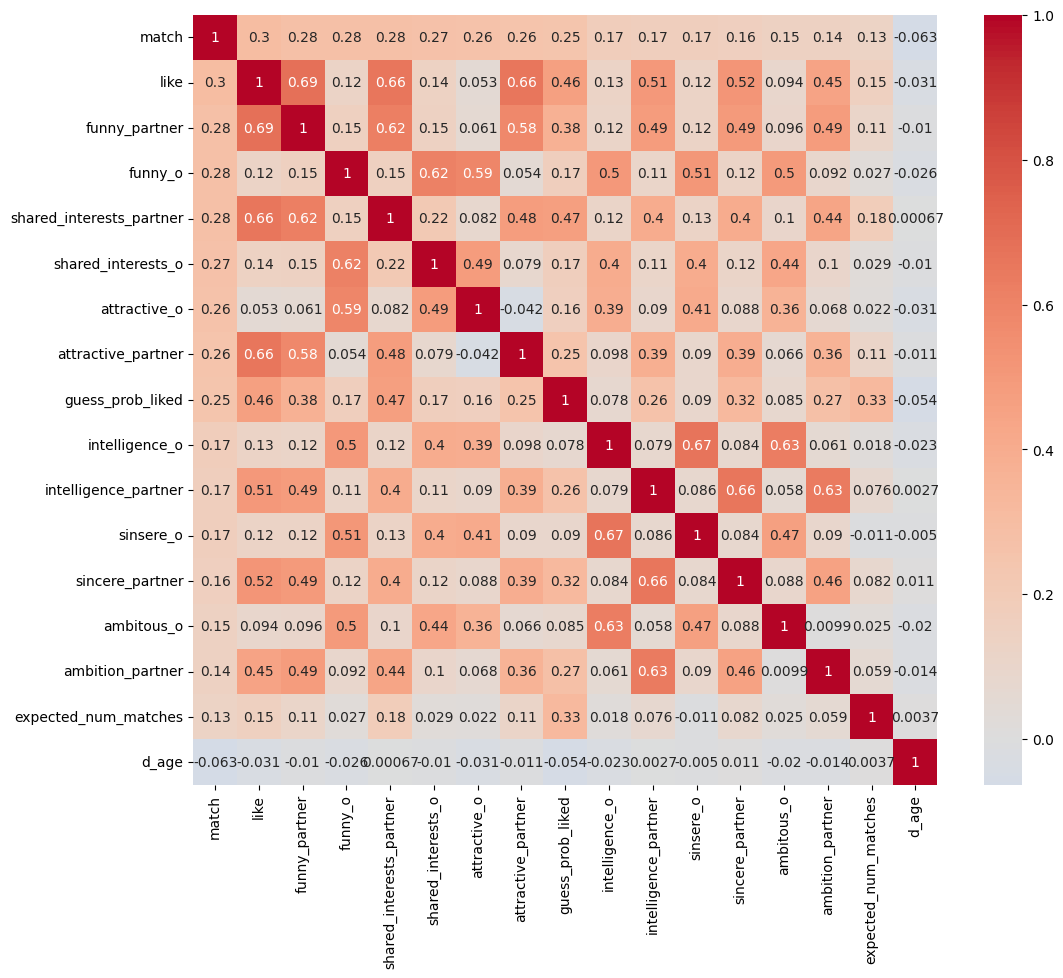

In [36]:
target_corr = df_clean.select_dtypes(include='number').corr()['match'].sort_values(ascending=False)
target_corr = target_corr.drop(["decision_o", "decision"], errors="ignore")
top_features = target_corr.abs().sort_values(ascending=False).head(17).index

plt.figure(figsize=(12,10))
sns.heatmap(df_clean[top_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.show()

### V tejto sekcii sme:
- Vyberie **nebinárne** stĺpce z `top_features`.
- Rozloží grafy do mriežky (3 stĺpce) podľa počtu vybraných stĺpcov.
- Pre každý stĺpec vykreslí **boxplot** (`seaborn.boxplot`).
- Odstráni prázdne osi, zarovná rozloženie a zobrazí graf.


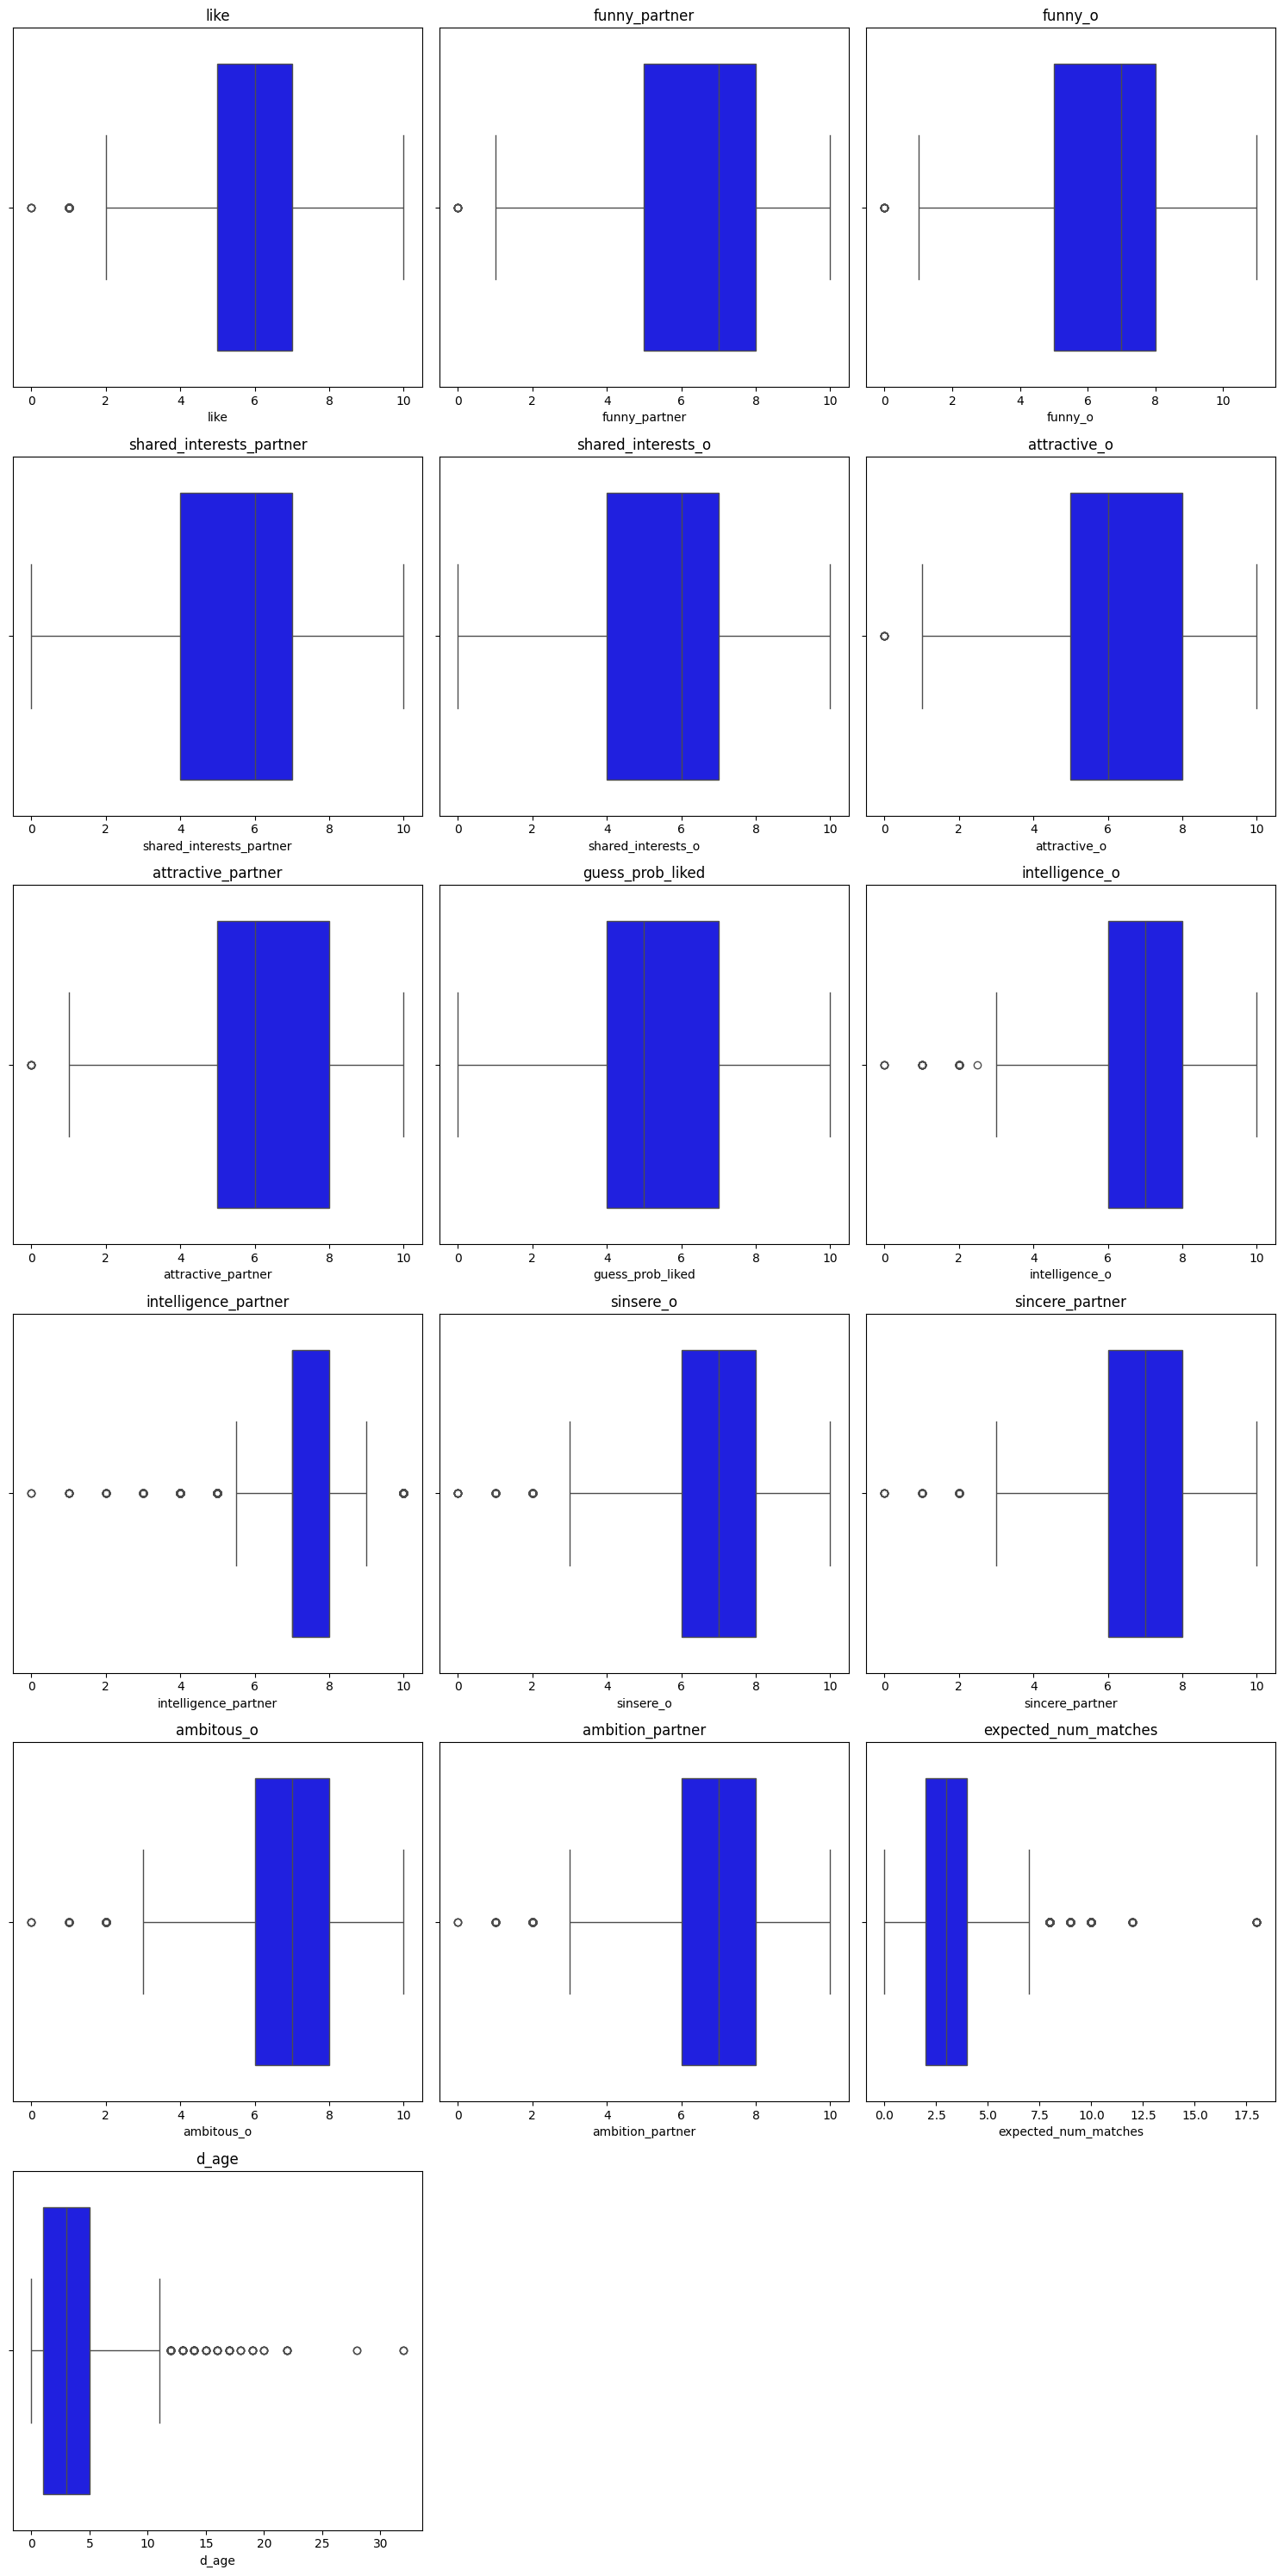

In [37]:
#Boxploty pre najviac korelujúce stĺpce, mimo tie čo majú binárnu hodnotu
cols = [c for c in top_features if df_clean[c].nunique() > 2]

n = len(cols)
rows = math.ceil(n / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten()
for ax, col in zip(axes, cols):
    sns.boxplot(x=df_clean[col], ax=ax, color="blue")
    ax.set_title(col)
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Riešenie outlierov
- Použijeme **Z-skóre** s hranicou `3` (|z| > 3) na detekciu outlierov v každom číselnom stĺpci.
- Pre každý stĺpec vypočítame priemer, smerodajnú odchýlku, Z-skóre a **spočítame počet outlierov**.
- Indexy riadkov s aspoň jedným outlierom ukladáme do množiny **`indexy_z`** (unikátne riadky).
- Výstup: prehľad počtov outlierov na stĺpec + množina riadkov na ďalšie spracovanie (odstránenie/kapovanie/imputácia).


In [38]:
def identify_outliers_z(df, hranica = 3):
    mean = df.mean()
    std = df.std()
    z_skore = (df-mean)/std
    return df[np.abs(z_skore) > hranica]

indexy_z = set()

print("Počet outlierov")
for col in df_clean.select_dtypes(include=[np.number]):
    outliers_z = identify_outliers_z(df_clean[col])
    if len(outliers_z)>0:
        print(f"{col}: {len(outliers_z)}")
        indexy_z.update(outliers_z.index)

Počet outlierov
age: 55
age_o: 44
d_age: 87
pref_o_attractive: 133
pref_o_sincere: 85
pref_o_intelligence: 123
pref_o_funny: 60
pref_o_ambitious: 21
attractive_o: 7
sinsere_o: 43
intelligence_o: 49
funny_o: 12
ambitous_o: 43
attractive_important: 138
sincere_important: 85
intellicence_important: 82
funny_important: 60
ambtition_important: 22
attractive: 18
sincere: 128
intelligence: 55
funny: 77
ambition: 82
attractive_partner: 6
sincere_partner: 39
intelligence_partner: 38
funny_partner: 8
ambition_partner: 36
dining: 62
museums: 13
gaming: 65
reading: 9
theater: 13
movies: 59
concerts: 13
music: 73
interests_correlate: 4
expected_num_matches: 48
like: 4


### Riesenie vychylenych hodnot pomocou Z-score
Vyberáme numerické stĺpce (prednostne tie s ≥22 rôznymi hodnotami) a počítame priemery/štandardné odchýlky s ignorovaním NaN.  
Z-skóre rátame so zabezpečením proti deleniu nulou a nahrádzame ±∞ za NaN.  
Outliery ohraničujeme (winsorization) na interval ⟨mean ± k·σ⟩, kde k = 3, čím vznikne `df_wins`.  
Vypíšeme počet outlierov pre `d_age` a zobrazíme tri boxploty: pôvodné dáta, Z-skóre a dáta po orezaní.



Počet outlierov podľa z-skóre (|z| > 3):
d_age: 223


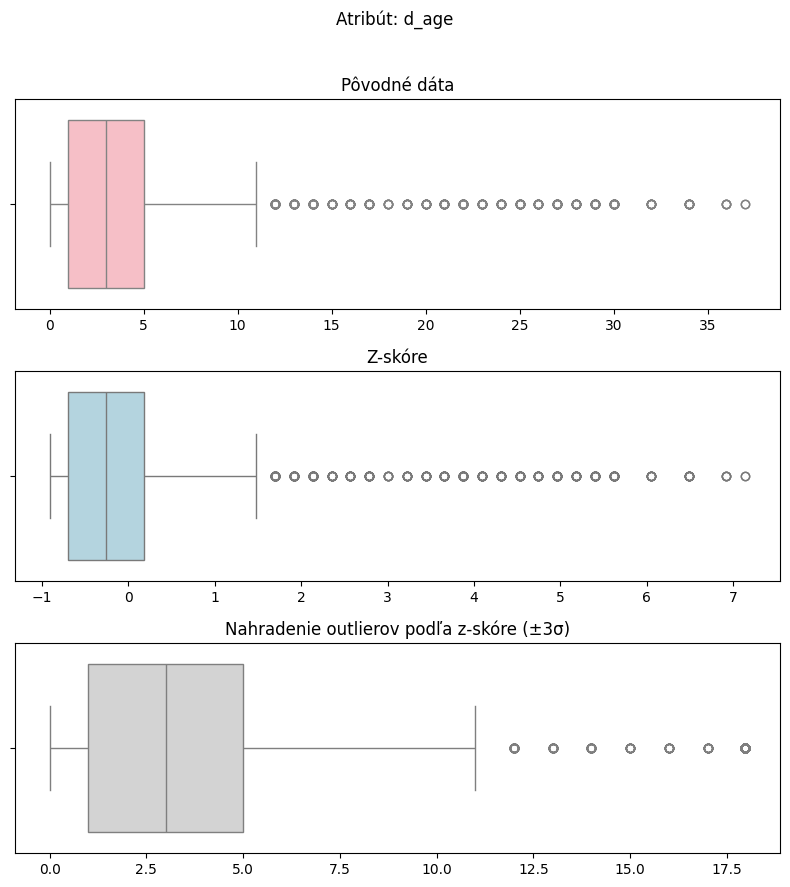

In [39]:
# to je pre z score
k = 3

#vybral som len tie ktoré majú aspoň 22 rôznych hodnôt
num_cols = df.select_dtypes(include='number').columns
columns_of_interest = [c for c in df_clean if df[c].nunique() > 22]

cols = [c for c in columns_of_interest if c in num_cols]
if not cols: 
    cols = list(num_cols)

means = df[cols].mean(skipna=True) #ignorujem nan hodnoty
stds  = df[cols].std(skipna=True) 
stds_safe = stds.replace(0, np.nan) #nechceme delit nulou tak radsej dame ako nan
z_df  = (df[cols] - means) / stds_safe
z_df  = z_df.replace([np.inf, -np.inf], np.nan)
lower = means - k * stds
upper = means + k * stds
df_wins = df.copy()
df_wins[cols] = df[cols].clip(lower=lower, upper=upper, axis=1)


print(f"\nPočet outlierov podľa z-skóre (|z| > {k}):")

pocet = (np.abs(z_df["d_age"]) > k).sum(skipna=True)
print(f"d_age: {pocet}")


fig, axes = plt.subplots(3, 1, figsize=(8, 9))
fig.suptitle("Atribút: d_age", y=0.98)
#povodne data
sns.boxplot(x=df["d_age"], ax=axes[0], color='lightpink')
axes[0].set_title("Pôvodné dáta")
axes[0].set_xlabel("")
 #z-score
sns.boxplot(x=z_df["d_age"], ax=axes[1], color='lightblue')
axes[1].set_title("Z-skóre")
axes[1].set_xlabel("")
#nahradim to podla z-score
sns.boxplot(x=df_wins["d_age"], ax=axes[2], color='lightgray')
axes[2].set_title(f"Nahradenie outlierov podľa z-skóre (±{k}σ)")
axes[2].set_xlabel("")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### Len výpis pre lepšie pochopenie

In [40]:
print(columns_of_interest)

['age', 'age_o', 'd_age', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'interests_correlate']


---

## **Rozdelenie dát**

### Pred rozdelením dát ich musíme ešte:
- Náhodne premiešať (je vhodné si zvoliť random_state pre reprodukovateľnosť výsledkov)
- Stratifíkovať dáta podľa cieľovej premennej (match) - robí sa to vtedy keď je cieľová premenná nevyvážená (čo je náš prípad)
  - Chceme zabezpečiť, aby každá množina mala približne rovnaké zastúpenie každej kategórie


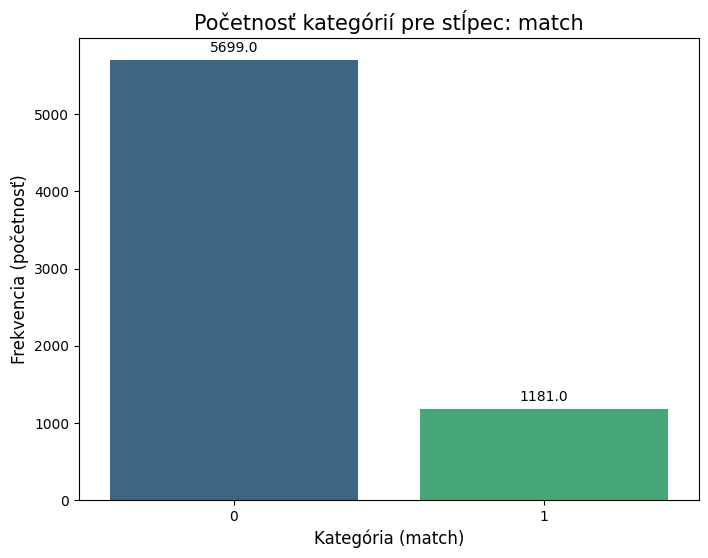

In [41]:
plt.figure(figsize=(8, 6))

# Funkcia sns.countplot automaticky vypočíta počet výskytov každej kategórie
ax = sns.countplot(x="match", data=df_clean, hue="match", legend=False, palette="viridis")

# Nastavenie popiskov a názvu
plt.title(f'Početnosť kategórií pre stĺpec: {"match"}', fontsize=15)
plt.xlabel(f'Kategória ({"match"})', fontsize=12)
plt.ylabel('Frekvencia (početnosť)', fontsize=12)

# Vloženie presných čísel (početnosti) nad každý stĺpec
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

#### Vidímé že naša predikovaná premenná "match" je **VEĽMI** nevyvážená, preto budeme stratifíkovať dáta pri ich delení. Neskôr pri tréningu modelu môžeme tiež použiť techniky ako oversampling, undersampling alebo váhovanie tried na riešenie tejto nevyváženosti. No nechceli by sme veľmi zasahovať do dát.

### Po testovaní na experimentoch *DOWNSAMPLING* a *OVERSAMPLING*:

Obe metódy vyváženia tried sa ukázali ako **neefektívne**.  
*Downsampling* znížil množstvo dát a tým aj schopnosť modelu generalizovať,  
zatým čo *oversampling* (napr. pomocou `SMOTE`) len **zhoršil výsledky** —  
*F1 skóre* kleslo z **0.55** na **0.45** pri rovnakých dátach a nastaveniach modelu.  
Preto sme sa rozhodli ponechať pôvodné, nevyvážené dáta. Nie je to najlepšia cesta, najlepšie by bolo doplňiť dáta tak aby bol pomer match, čo najviac vyvážený.


---

### **FEATURE SELECITON**

##### Zaradime si parametre, ktoré budeme sledovať

In [42]:
TOP_K = 20
VOTE_THRESHOLD = 3
TARGET = "match"  # zmeň ak sa cieľ volá inak
RANDOM_STATE = 45

 Príprava dát: y, numerické X a imputácia NaN + Škálovania pre jednotlivé metódy

In [43]:

#priprava dat
y = df_clean[TARGET].to_numpy()
X_num = df_clean.drop(columns=[TARGET]).select_dtypes(include=[np.number])

imputer = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns, index=X_num.index)
feature_names = X_imp.columns.to_numpy()


# skalovanie
df_all    = X_imp.copy()
df_std    = pd.DataFrame(StandardScaler().fit_transform(df_all), columns=feature_names, index=df_all.index)
df_nonneg = pd.DataFrame(MinMaxScaler().fit_transform(df_all),   columns=feature_names, index=df_all.index)

transform_cols = feature_names  # pracujeme na rovnakom zozname featur

Jednotlivé skóringy a poradia (VAR, MI, CHI², ANOVA, RFE, SFM)

In [44]:
# 4.1 Variancia (vyššia = lepšie)
variances = df_all[transform_cols].var()
df_var = (pd.DataFrame({'Feature': transform_cols, 'Var_Score': variances.values})
          .sort_values('Var_Score', ascending=False).reset_index(drop=True))
df_var['Rank'] = df_var['Var_Score'].rank(method='dense', ascending=False).astype(int)

# 4.2 Mutual Information
mi = mutual_info_classif(df_all[transform_cols], y, discrete_features='auto', random_state=RANDOM_STATE)
df_mic = (pd.DataFrame({'Feature': transform_cols, 'MI_Score': mi})
          .sort_values('MI_Score', ascending=False).reset_index(drop=True))
df_mic['Rank'] = df_mic['MI_Score'].rank(method='dense', ascending=False).astype(int)

# 4.3 Chi-squared (potrebuje nezáporné dáta)
skb_chi = SelectKBest(score_func=chi2, k='all').fit(df_nonneg[transform_cols], y)
df_chi = (pd.DataFrame({'Feature': transform_cols, 'Chi2_Score': skb_chi.scores_})
          .sort_values('Chi2_Score', ascending=False).reset_index(drop=True))
df_chi['Rank'] = df_chi['Chi2_Score'].rank(method='dense', ascending=False).astype(int)

# 4.4 ANOVA (f_classif)
skb_f = SelectKBest(score_func=f_classif, k='all').fit(df_all[transform_cols], y)
df_f = (pd.DataFrame({'Feature': transform_cols, 'F_Score': skb_f.scores_})
        .sort_values('F_Score', ascending=False).reset_index(drop=True))
df_f['Rank'] = df_f['F_Score'].rank(method='dense', ascending=False).astype(int)

# 4.5 RFE (LogReg) – použijeme n_features_to_select=1 na získanie plného poradia
est_rfe = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
rfe = RFE(estimator=est_rfe, n_features_to_select=1, step=1).fit(df_std[transform_cols], y)
df_rfe = pd.DataFrame({'Feature': transform_cols, 'Rank': rfe.ranking_}).sort_values('Rank', ascending=True).reset_index(drop=True)

# 4.6 SelectFromModel (LogReg, veľkosť koeficientov)
est_sfm = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE).fit(df_std[transform_cols], y)
importances = np.abs(est_sfm.coef_[0])
df_sfm = (pd.DataFrame({'Feature': transform_cols, 'Importance': importances})
          .sort_values('Importance', ascending=False).reset_index(drop=True))
df_sfm['Rank'] = df_sfm['Importance'].rank(method='dense', ascending=False).astype(int)


TOP_K z každej metódy a hlasovanie

In [45]:
def topk_names(df, score_col_or_rank, by_score_desc=True):
    if score_col_or_rank == 'Rank':
        return df.sort_values('Rank', ascending=True)['Feature'].head(TOP_K).tolist()
    return df.sort_values(score_col_or_rank, ascending=not by_score_desc)['Feature'].head(TOP_K).tolist()

tops = {
    'VAR': topk_names(df_var, 'Var_Score', by_score_desc=True),
    'MI' : topk_names(df_mic, 'MI_Score', by_score_desc=True),
    'CHI': topk_names(df_chi, 'Chi2_Score', by_score_desc=True),
    'F'  : topk_names(df_f,   'F_Score', by_score_desc=True),
    'RFE': topk_names(df_rfe, 'Rank'),
    'SFM': topk_names(df_sfm, 'Importance', by_score_desc=True),
}

rank_maps = {
    'VAR': {f:i+1 for i,f in enumerate(df_var.sort_values('Var_Score',  ascending=False)['Feature'])},
    'MI' : {f:i+1 for i,f in enumerate(df_mic.sort_values('MI_Score',   ascending=False)['Feature'])},
    'CHI': {f:i+1 for i,f in enumerate(df_chi.sort_values('Chi2_Score', ascending=False)['Feature'])},
    'F'  : {f:i+1 for i,f in enumerate(df_f.sort_values('F_Score',      ascending=False)['Feature'])},
    'RFE': {f:i+1 for i,f in enumerate(df_rfe.sort_values('Rank',       ascending=True )['Feature'])},
    'SFM': {f:i+1 for i,f in enumerate(df_sfm.sort_values('Importance', ascending=False)['Feature'])},
}

votes = Counter()
ranks = defaultdict(list)

for method, feat_list in tops.items():
    for f in feat_list:
        votes[f] += 1
        ranks[f].append(rank_maps[method][f])

final = []
for f, v in votes.items():
    if v >= VOTE_THRESHOLD:
        avg_r = float(np.mean(ranks[f]))
        final.append((f, v, avg_r))

if not final:  # fallback, ak nič neprešlo prahom hlasov
    for f, v in votes.most_common(TOP_K):
        final.append((f, v, float(np.mean(ranks[f]))))

final_df = (pd.DataFrame(final, columns=['Feature','Votes','Avg_Rank'])
            .sort_values(['Votes','Avg_Rank'], ascending=[False, True])
            .reset_index(drop=True))

SELECTED_FEATURES = final_df['Feature'].tolist()


Výstup a príprava matíc pre model

In [46]:
print(f"FINÁLNE NAJLEPŠIE FEATURES (TOP_{TOP_K} v >= {VOTE_THRESHOLD} metódach)")
print(final_df.to_string(index=False))

X_fs = X_imp[SELECTED_FEATURES].to_numpy(dtype=np.float32)
y_fs = y.astype(np.float32)

print("\nPRIPRAVENÉ PRE MODEL")
print("SELECTED_FEATURES:", SELECTED_FEATURES)
print("X_fs shape:", X_fs.shape, " y_fs shape:", y_fs.shape)

# voliteľne: pridaj ďalšie (napr. kategórie) do zoznamu featur pre ďalšie spracovanie mimo X_imp
SELECTED_FEATURES.extend(['race', 'race_o', 'gender', 'field'])


FINÁLNE NAJLEPŠIE FEATURES (TOP_20 v >= 3 metódach)
                 Feature  Votes  Avg_Rank
                    like      5  1.800000
                 funny_o      5  3.400000
      shared_interests_o      5  4.200000
            attractive_o      5  4.200000
           funny_partner      5  5.000000
      attractive_partner      5  5.400000
        guess_prob_liked      5  5.400000
shared_interests_partner      5  9.800000
    expected_num_matches      5 11.600000
        ambition_partner      5 12.800000
                   d_age      5 16.200000
              ambitous_o      4 11.250000
     pref_o_intelligence      4 11.750000
    attractive_important      3 10.333333
          intelligence_o      3 10.333333
         sincere_partner      3 12.000000
       sincere_important      3 13.000000
    intelligence_partner      3 14.000000
     ambtition_important      3 15.333333
importance_same_religion      3 17.000000
    importance_same_race      3 17.333333

PRIPRAVENÉ PRE MODEL
SE

---

### Rozdelenie dát na `Trénovaciu, Validačnú a Testovaciu množinu`


Pomer Rozdelenie:
- Trénovacia množina (70% dát) - na trénovanie modelu
- Validačná množina (15% dát) - na testovani správnosti modelu počas tréningu
- Testovacia množina (15% dát) - na finálne otestovanie modelu

Tento pomer môže byť aj iný ale 70/15/15 je bežný štandard. Neskôr sme testovali aj iné pomery ako 80/10/10 alebo aj kompletné vyhodenie *VALIDACNEJ* mnoziny ale výsledok nebol ideálny. Dokonca sme dostávali horšie výsledky



>  Toto je iny df, je zlozeny len z Selected features z TOP najlepsich atributov. Vysledok bol rovnaky ako ked sme pouzili vsetkych 70. Viditeľné zmeny nenastali. 
 **Recall** bol otrocha vyšší no F1 a accurancy rovanké

In [47]:
df_clean_fs = df_clean[SELECTED_FEATURES + [TARGET]].copy()

#Ďalej sme používali už len df_clean
X_temp, X_test, y_temp, y_test = train_test_split(
    df_clean.drop(columns=['match']),
    df_clean['match'],
    test_size=0.15,
    random_state=69,
    stratify=df_clean['match']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  #toto je priblizne 15% povodnych dat
    random_state=69,
    stratify=y_temp
)

print(f"Tréningová množina: {X_train.shape[0]} vzoriek")
print(f"Validačná množina: {X_val.shape[0]} vzoriek")
print(f"Testovacia množina: {X_test.shape[0]} vzoriek")

Tréningová množina: 4815 vzoriek
Validačná množina: 1033 vzoriek
Testovacia množina: 1032 vzoriek


---

## Tvorba **PIPELINE**

Trieda **`FieldCleaner`** čistí a zjednocuje názvy študijných odborov.  
Text prevádza na **malé písmená**, odstráni znaky mimo abecedy a mapuje synonymá podľa slovníka `replacements`.  
Neznáme alebo prázdne hodnoty nahrádza reťazcom **`'missing'`**.  
Je kompatibilná so **scikit-learn pipeline** (`fit`, `transform`).


In [48]:
class FieldCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, replacements=None):
        # replacment čo nás napadlo
        self.replacements = replacements or {
            'eng': 'engineering',
            'engineer': 'engineering',
            'computer science': 'cs',
            'comp sci': 'cs',
            'information technology': 'cs',
            'law school': 'law',
            'psych': 'psychology',
            'psychological': 'psychology',
            'biz': 'business',
            'econ': 'economics',
            'bio': 'biology',
            'bioinformatics': 'biology',
            'edu': 'education',
            'teacher': 'education',
            'med': 'medicine',
            'pre med': 'medicine',
            'art history': 'arts',
            'art': 'arts'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        col = X.columns[0]
        s = X[col].astype(str).str.lower().str.strip()
        s = s.apply(lambda x: re.sub(r'[^a-z\s]', '', x))

        def normalize(x):
            for k, v in self.replacements.items():
                if k in x:
                    return v
            return x

        s = s.apply(normalize)

        s = s.replace(['nan', 'none', 'unknown', '', ' '], np.nan)
        s = s.fillna('missing')

        X[col] = s
        return X

#### Naša PIPELINE
*Predspracovanie* riešime cez **ColumnTransformer**:  
- `num_cols` → **KNNImputer(5)** + **StandardScaler**.  
- `['race','race_o','gender']` → **SimpleImputer('missing')** + **OneHotEncoder** (`handle_unknown='ignore'`).  
- `['field']` → **FieldCleaner** + **TargetEncoder** (`smoothing=50`).  

Všetko je zabalené v **Pipeline** (`final_pipeline`), fitnuté na `X_train, y_train`.  
Po transformácii počítame počet výstupných featur cez `preprocessor.transform(...).shape[1]` → uložené v `n_features`.


In [ ]:
gender_races_cols = ['race','race_o','gender']
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
field_cols = ['field']

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())])

race_gender_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

field_transformer = Pipeline(steps=[
    ('clean', FieldCleaner()),
    ('target', TargetEncoder(
        cols=['field'],
        smoothing=50.0,
        handle_missing='value',
        handle_unknown='value')),])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('gen_race', race_gender_transformer, gender_races_cols),
        ('field', field_transformer, field_cols)],remainder='drop')

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),])

final_pipeline.fit(X_train, y_train)

n_features = preprocessor.transform(X_train[:5]).shape[1]

### V tejto sekcii sa logujeme do Wandb, ktoré používame na trackovanie experimentov

In [50]:
wandb.login()

wandb: Currently logged in as: xvachd (xkmetk-slovak-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Najprv **fitneme preprocessor** (kvôli `TargetEncoder`, ktorý potrebuje aj `y`).  
Potom transformujeme všetky datasety (`train`, `val`, `test`) na číselné matice typu **float32**.  
Premenné `y_*` tiež konvertujeme na `float32` pre konzistenciu.  
Na záver zistíme a vypíšeme **počet vstupných príznakov** (`n_features`) po transformácii.

In [ ]:
preprocessor.fit(X_train, y_train)

X_train_prep = preprocessor.transform(X_train).astype(np.float32)
X_val_prep = preprocessor.transform(X_val).astype(np.float32)
X_test_prep = preprocessor.transform(X_test).astype(np.float32)

y_train_float = y_train.to_numpy().astype(np.float32)
y_val_float = y_val.to_numpy().astype(np.float32)
y_test_float = y_test.to_numpy().astype(np.float32)

n_features = X_train_prep.shape[1]
print(f"Počet príznakov na vstupe do modelu: {n_features}")

Počet príznakov na vstupe do modelu: 71


### Viac detailov k **`MLPModule`** (PyTorch)



**Parametre:**
- `input_features`: počet vstupných príznakov (dimenzia vstupu).
- `hidden_layers: List[int]`: veľkosti skrytých vrstiev (napr. `[256,128,64]`).
- `dropout_rate` *(default 0.5)*: pravdepodobnosť vypúšťania neurónov pre regularizáciu.
- `use_batch_norm` *(default True)*: ak **True**, za každú lineárnu vrstvu vloží **BatchNorm1d**.
- `activation_fn` *(default `nn.ReLU`)*: trieda aktivácie (napr. `nn.ReLU`, `nn.GELU`, `nn.LeakyReLU`).

**Architektúra vrstiev (opakuje sa pre každú hodnotu v `hidden_layers`):**  
`Linear(in → h)` → *(voliteľne)* `BatchNorm1d(h)` → `Activation()` → `Dropout(p)`  
Na konci je **výstupná lineárna vrstva** `Linear(last_h → 1)` bez aktivácie.

**Prečo takto:**
- **BatchNorm** stabilizuje a zrýchľuje tréning (hlavne pri hlbších MLP).
- **Dropout** znižuje preučenie (*overfitting*).
- **Flexibilná aktivácia** cez `activation_fn()` umožní rýchlo testovať ReLU/GELU/LeakyReLU bez zmeny kódu.
- **`squeeze(-1)`** mení tvar z `(N,1)` na `(N,)` – praktické pre `BCEWithLogitsLoss`.

**`forward` priechod:**
- Konvertuje vstup `X` na `float` (`float32`) a preženie ho cez `self.network` (sekvencia vrstiev).
- Vráti vektor logitov dĺžky `N`.

**Použitie (príklad):**
```python
model = MLPModule(
    input_features=n_features,
    hidden_layers=[256, 128, 64],
    dropout_rate=0.4,
    use_batch_norm=True,
    activation_fn=nn.ReLU,   # alebo nn.GELU
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [ ]:
class MLPModule(nn.Module):
    def __init__(self,
                 input_features,
                 hidden_layers,
                 dropout_rate=0.5,
                 use_batch_norm=True,
                 activation_fn=nn.ReLU):

        super(MLPModule, self).__init__()

        layers = []
        in_feats = input_features

        for h_feats in hidden_layers:
            layers.append(nn.Linear(in_feats, h_feats))

            if use_batch_norm:
                layers.append(nn.BatchNorm1d(h_feats))

            layers.append(activation_fn()) # <-- Použitie flexibilnej aktivácie
            layers.append(nn.Dropout(dropout_rate))
            in_feats = h_feats

        layers.append(nn.Linear(in_feats, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, X, **kwargs):
        X = X.float()
        return self.network(X).squeeze(-1)

### Ako experiment sme vyskúšali aj MultiLayer Perceptrone so skipovaním niektorých connections

### **Skip connections** v `MLPWithSkipConnections` 

**Ako to beží v bloku:**
- `F(x)`: `Linear → (BatchNorm) → activation → Dropout`.
- `P(x)`: `Identity` ak `in_dim == out_dim`, inak `Linear → (BatchNorm)` na zarovnanie rozmerov.
- **Sčítanie** `F(x) + P(x)` a následná **post-add aktivácia** (`activation_fn`).

**Prečo?** *residual* prepojenie uľahčuje prenos gradientov (menej miznú), chráni informáciu identity a umožní stavať **hlbšie a stabilnejšie** MLP.



In [ ]:
class MLPWithSkipConnections(nn.Module):
    def __init__(self,
                 input_features,
                 hidden_layers,
                 dropout_rate=0.3,
                 use_batch_norm=True,
                 activation_fn=nn.ReLU): 

        super().__init__()

        self.blocks = nn.ModuleList()
        self.projections = nn.ModuleList() 

        in_dim = input_features
        for out_dim in hidden_layers:
 
            block_layers = []
            block_layers.append(nn.Linear(in_dim, out_dim))
            if use_batch_norm:
                block_layers.append(nn.BatchNorm1d(out_dim))
            block_layers.append(activation_fn())
            block_layers.append(nn.Dropout(dropout_rate))

            self.blocks.append(nn.Sequential(*block_layers))

            if in_dim != out_dim:

                projection_layers = [nn.Linear(in_dim, out_dim)]
                if use_batch_norm:
                    projection_layers.append(nn.BatchNorm1d(out_dim))
                self.projections.append(nn.Sequential(*projection_layers))
            else:
                self.projections.append(nn.Identity())
            in_dim = out_dim


        self.output_layer = nn.Linear(in_dim, 1)


        self.post_add_activation = activation_fn()

    def forward(self, x, **kwargs):
        x = x.float()

        for block, projection in zip(self.blocks, self.projections):
            identity = x
            f_x = block(x)
            skip_x = projection(identity)
            x = f_x + skip_x
            x = self.post_add_activation(x)

        x = self.output_layer(x)
        return x.squeeze(-1) 

#### Definovanie rôznych experimentov

In [ ]:
experiments = [
    {
        'name': 'exp_pos_w_2',
        'lr': 0.0008,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128],
        'module__dropout_rate': 0.3
    },
    {
        'name': 'Maly_model_rychly_LR',
        'lr': 0.005,
        'max_epochs': 50,
        'batch_size': 256,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [64, 32],
        'module__dropout_rate': 0.2,

    },
    {
        'name': 'Vacsi_model_pomaly_LR_RMSprop',
        'lr': 0.0005,
        'max_epochs': 150,
        'batch_size': 512,
        'optimizer': torch.optim.RMSprop,
        'module__hidden_layers': [256, 128, 64],
        'module__dropout_rate': 0.4,
    },
    {
        'name': 'Hlboky_model_vysoky_dropout',
        'lr': 0.001,
        'max_epochs': 150,
        'batch_size': 256,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128, 64],
        'module__dropout_rate': 0.6,
    },
    {
        'name': 'Hlboky_model_vysoky_dropout',
        'lr': 0.01,
        'max_epochs': 500,
        'batch_size': 512,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128, 64],
        'module__dropout_rate': 0.2,
    },
    {
        'name': 'Test_5_F1_0.576',
        'lr': 0.001,
        'max_epochs': 80,
        'batch_size': 512,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [256, 128],
        'module__dropout_rate': 0.2,
    },
    {
        'name': 'Test_5_F1_0.571',
        'lr': 0.002,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [640, 320, 160],
        'module__dropout_rate': 0.3,
    },

    {
        'name': 'Test_9_F1_0.577',
        'lr': 0.001,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256],
        'module__dropout_rate': 0.4,
    },

    {
        'name': 'Test_26_F1_0.573',
        'lr': 0.0006,
        'max_epochs': 60,
        'batch_size': 512,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [640, 320, 160],
        'module__dropout_rate': 0.3,
    },
]

### V Tejto časti testujeme vyššie definované experimenty, ktoré evidujeme vo WANDB-i. Najprv otestujeme dané vstupy na našej MLP sieti a potom ich zaevidujeme do wanbd. Takto iterujeme cez všetky experimenty

In [ ]:

valid_ds = Dataset(X_val_prep, y_val_float)

count_0 = np.sum(y_train_float == 0)
count_1 = np.sum(y_train_float == 1)

pos_weight_value = count_0 / count_1

print(f"Počet vzoriek 0: {count_0}")
print(f"Počet vzoriek 1: {count_1}")
print(f"Vypočítaná váha 'pos_weight': {pos_weight_value:.4f}")

pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)

for i, exp_params in enumerate(experiments):

    start_time = time.time()
    print(f"\n--- Spúšťam experiment {i+1}/{len(experiments)}: {exp_params['name']} ---")

    run = wandb.init(
        project="SpeedDating-MLP",
        name=exp_params['name'],
        config=exp_params
    )

    callbacks = [
        ('val_f1', EpochScoring(
            scoring='f1',
            lower_is_better=False,
            on_train=False,
            name='val_f1'
        )),
        ('early_stop', EarlyStopping(
            monitor='val_f1',
            patience=10,
            lower_is_better=False
        )),
        ('wandb_logger', WandbLogger(wandb_run=run))
    ]

    torch.manual_seed(69)
    net = NeuralNetBinaryClassifier(
        module=MLPWithSkipConnections,
        module__input_features=n_features,
        criterion=torch.nn.BCEWithLogitsLoss,
        criterion__pos_weight=pos_weight_tensor,
        train_split=predefined_split(valid_ds),  

        verbose=0,
        callbacks=callbacks,
        **{k: v for k, v in exp_params.items() if k != 'name'}
    )
    net.fit(X_train_prep, y_train_float)

    y_pred_test = net.predict(X_test_prep)
    y_proba_test = net.predict_proba(X_test_prep)[:, 1]

    test_f1 = f1_score(y_test, y_pred_test)
    test_logloss = log_loss(y_test, y_proba_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    test_cm = confusion_matrix(y_test, y_pred_test)
    test_report = classification_report(y_test, y_pred_test)

    print(f"Test F1: {test_f1:.4f} | Test LogLoss: {test_logloss:.4f} | Test Acc: {test_accuracy:.4f}")

    print(f"Test Confusion Matrix:\n{test_cm}")
    print(f"Test Classification Report:\n{test_report}")


    wandb.log({
        "test_f1": test_f1,
        "test_logloss": test_logloss,
        "test_accuracy": test_accuracy,
        "training_time_s": time.time() - start_time,
        "best_epoch": net.history_[-1, 'epoch']
    })

    run.finish()

print("\n--- Všetky experimenty dokončené ---")

Počet vzoriek 0: 3988
Počet vzoriek 1: 827
Vypočítaná váha 'pos_weight': 4.8222

--- Spúšťam experiment 1/9: exp_pos_w_2 ---


Test F1: 0.5526 | Test LogLoss: 0.4398 | Test Acc: 0.8353
Test Confusion Matrix:
[[757  98]
 [ 72 105]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       855
           1       0.52      0.59      0.55       177

    accuracy                           0.84      1032
   macro avg       0.72      0.74      0.73      1032
weighted avg       0.85      0.84      0.84      1032



best_epoch,▁
dur,█▄▃▁▆▁▆▄▂▁▂▆▃▇▇
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
training_time_s,▁
val_f1,▁▂▅▅▆█▆▅▇██▆▆█▇
valid_acc,▁▂▅▅▆▇▆▆▇▇█▇█▇█
valid_loss,▄▃▂▁▁▁▂▂▃▄▄▄▆▆█
best_epoch,16



--- Spúšťam experiment 2/9: Maly_model_rychly_LR ---


Test F1: 0.5237 | Test LogLoss: 0.7553 | Test Acc: 0.8149
Test Confusion Matrix:
[[736 119]
 [ 72 105]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       855
           1       0.47      0.59      0.52       177

    accuracy                           0.81      1032
   macro avg       0.69      0.73      0.70      1032
weighted avg       0.84      0.81      0.82      1032



best_epoch,▁
dur,▄▃▂▃▃▃▃▂█▃▂▃▂▁▂▁▁▁▃▁▂▂
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
training_time_s,▁
val_f1,▄▁▅▄▂▂▄▂▁▅▅▅█▆▆▇▆▄▃▅▃▄
valid_acc,▂▁▄▆▄▆▅▅▆▇▇▇██▇▇▇█▆▇▇▇
valid_loss,▁▁▁▁▂▂▂▃▃▄▄▅▄▅▆▆▆▇▇▇█▆
best_epoch,23



--- Spúšťam experiment 3/9: Vacsi_model_pomaly_LR_RMSprop ---


Test F1: 0.5446 | Test LogLoss: 0.4682 | Test Acc: 0.8217
Test Confusion Matrix:
[[738 117]
 [ 67 110]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       855
           1       0.48      0.62      0.54       177

    accuracy                           0.82      1032
   macro avg       0.70      0.74      0.72      1032
weighted avg       0.84      0.82      0.83      1032



best_epoch,▁
dur,▃▁▂▂▃▃▄▂▃▃▄▃▂▂▃▂▁▁▂▂▁▂▁▂█▆▅▄
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
training_time_s,▁
val_f1,▁▂▃▅▅▃▅▄▅▆▄▃▆▇▇▇█▇█▅▆▆█▅▅▅▅▃
valid_acc,▁▁▂▄▄▂▅▄▅▅▄▃▇▆▇▅▇█▇▇▇▇▇▇▇██▇
valid_loss,▂▁▁▁▁▁▂▂▂▂▂▂▄▃▄▂▄▄▄▅▄▅▅▆▇▇█▇
best_epoch,29



--- Spúšťam experiment 4/9: Hlboky_model_vysoky_dropout ---


Test F1: 0.5558 | Test LogLoss: 0.5698 | Test Acc: 0.8188
Test Confusion Matrix:
[[728 127]
 [ 60 117]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       855
           1       0.48      0.66      0.56       177

    accuracy                           0.82      1032
   macro avg       0.70      0.76      0.72      1032
weighted avg       0.85      0.82      0.83      1032



best_epoch,▁
dur,▃▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▁▂▂▂▂▂▁▁▄▇█▂▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
training_time_s,▁
val_f1,▁▄▄▅▅▆▅▆▆▇▆▇▅▆▇▇▆▇▇██▇▅▇▆█▆▆▇
valid_acc,▁▄▄▅▅▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇█▇▆▇██▇██
valid_loss,▁▁▁▁▁▁▁▂▂▃▃▃▃▃▄▄▅▅▇▅▅▅▆▆▆▇▇██
best_epoch,30



--- Spúšťam experiment 5/9: Hlboky_model_vysoky_dropout ---


Test F1: 0.5592 | Test LogLoss: 0.7783 | Test Acc: 0.8198
Test Confusion Matrix:
[[728 127]
 [ 59 118]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       855
           1       0.48      0.67      0.56       177

    accuracy                           0.82      1032
   macro avg       0.70      0.76      0.72      1032
weighted avg       0.85      0.82      0.83      1032



best_epoch,▁
dur,▂▆█▁▁▄▃▃▃▅▁▃▂▄▆▃▁▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▅▄▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁
training_time_s,▁
val_f1,▁▃▅█▃▃▂▆▆█▆▃▇▄▅▆▅▅▅
valid_acc,▁▂▄▇▅▅▃▅▇▇▆▇▇▇▆█▇█▇
valid_loss,▃▂▁▂▃▄▃▂▄▅▄▇▅▆▆▆▆█▇
best_epoch,20



--- Spúšťam experiment 6/9: Test_5_F1_0.576 ---


Test F1: 0.5163 | Test LogLoss: 0.5493 | Test Acc: 0.8275
Test Confusion Matrix:
[[759  96]
 [ 82  95]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       855
           1       0.50      0.54      0.52       177

    accuracy                           0.83      1032
   macro avg       0.70      0.71      0.71      1032
weighted avg       0.83      0.83      0.83      1032



best_epoch,▁
dur,▃▁▁▁▁▁▁▁█▂▁▁▁▁▁▂▁▁▅▂▁▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
training_time_s,▁
val_f1,▁▃▄▅▃▆▇▅▇▇▇▇▄█▅▅▅▄▃▆▄▄▃
valid_acc,▁▂▂▄▃▄▅▆▆▆██▇█▇▇▆█▇██▇▇
valid_loss,▁▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▇▇█▆▇█
best_epoch,24



--- Spúšťam experiment 7/9: Test_5_F1_0.571 ---


Test F1: 0.4798 | Test LogLoss: 0.6155 | Test Acc: 0.8382
Test Confusion Matrix:
[[788  67]
 [100  77]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       855
           1       0.53      0.44      0.48       177

    accuracy                           0.84      1032
   macro avg       0.71      0.68      0.69      1032
weighted avg       0.83      0.84      0.83      1032



best_epoch,▁
dur,█▇▃▂▂▇▇▆▂▂▂▁▅▇▆▇▆▂▂
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▂▁▁▁
training_time_s,▁
val_f1,▂▄▃▄▅▆▆▅▆█▅█▁▆▅▅▇▆▄
valid_acc,▁▄▂▃▄▅▄▄▆▇▅▅█▆▆█▆▅▇
valid_loss,▁▁▁▁▁▂▂▂▃▄▄▄▇▅▅█▆▅▇
best_epoch,20



--- Spúšťam experiment 8/9: Test_9_F1_0.577 ---


Test F1: 0.5473 | Test LogLoss: 0.5284 | Test Acc: 0.8285
Test Confusion Matrix:
[[748 107]
 [ 70 107]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       855
           1       0.50      0.60      0.55       177

    accuracy                           0.83      1032
   macro avg       0.71      0.74      0.72      1032
weighted avg       0.84      0.83      0.83      1032



best_epoch,▁
dur,▂▁▂▁█▃▂▂▄▂▄▂▂▂▂▂▄▂▁▁▁▁▃▂▄▄▁▁▁▁▅▁▂
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
training_time_s,▁
val_f1,▁▁▂▂▄▅▃▄▅▅▄▅▆▇▆▅▅▆▇▇▆▄▆█▇▅▆▅▅▇▅▅▅
valid_acc,▁▂▅▅▅▆▅▅▅▅▅▆▇▇▆▆▇▇▇█▇▆▇▇▇▇█▇▇█▇██
valid_loss,▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▄▄▅▆▆▅▆▆▇█
best_epoch,34



--- Spúšťam experiment 9/9: Test_26_F1_0.573 ---


Test F1: 0.5361 | Test LogLoss: 0.5116 | Test Acc: 0.8256
Test Confusion Matrix:
[[748 107]
 [ 73 104]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       855
           1       0.49      0.59      0.54       177

    accuracy                           0.83      1032
   macro avg       0.70      0.73      0.71      1032
weighted avg       0.84      0.83      0.83      1032



best_epoch,▁
dur,██▂▆▁▁▄▁▁▄▁▁▃▆▃▁▁▂
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
training_time_s,▁
val_f1,▁▃▄▄▅▆▇▆█▅▆▇▅▇▄▅▆▇
valid_acc,▁▂▃▄▅▅▆▆▇▅█▇▆▇▆█▅█
valid_loss,▂▁▁▁▁▂▂▃▃▃▅▄▄▅▆█▅▇
best_epoch,19



--- Všetky experimenty dokončené ---


## Hyperparameter Search

In [ ]:

y_train_float = y_train.to_numpy().astype(np.float32)
y_val_float = y_val.to_numpy().astype(np.float32)
y_test_float = y_test.to_numpy().astype(np.float32)

print(f"Počet príznakov na vstupe do modelu: {n_features}")

torch.manual_seed(69)

Počet príznakov na vstupe do modelu: 71


In [ ]:

counts = y_train.value_counts()
n_negative = counts[0]
n_positive = counts[1]
pos_weight_value = n_negative / n_positive
print(f"Vypočítaná váha (pos_weight): {pos_weight_value:.4f}")
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)



net = NeuralNetBinaryClassifier(
    module=MLPModule,
    module__input_features=n_features,
    criterion=torch.nn.BCEWithLogitsLoss,
    train_split=ValidSplit(cv=0.2, stratified=True, random_state=69),
    verbose=0,
    callbacks=[
        ('f1_val', EpochScoring(scoring='f1', lower_is_better=False, on_train=False, name='val_f1')),
        ('early_stop', EarlyStopping(monitor='val_f1', patience=10, lower_is_better=False))
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', net)
])


param_grid = {
    'clf__lr': [1e-3, 5e-4],
    'clf__module__hidden_layers': [[128, 64], [256, 128, 64]],
    'clf__module__dropout_rate': [0.2, 0.5],
    'clf__batch_size': [256, 512],
    'clf__optimizer': [torch.optim.Adam, torch.optim.RMSprop],
    'clf__max_epochs': [100],
    'clf__criterion__pos_weight': [None, pos_weight_tensor],
    'clf__optimizer__weight_decay': [1e-4, 1e-5, 0],
    'clf__module__use_batch_norm': [True, False],
    'clf__module__activation_fn': [nn.ReLU, nn.LeakyReLU, nn.GELU]
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=69)

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    refit=True,
    verbose=2
)

Vypočítaná váha (pos_weight): 4.8222


In [58]:
# Spustenie trénovania (môže to trvať dlhšie)
gs.fit(X_train, y_train_float)

print("Trénovanie dokončené.")

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


KeyboardInterrupt: 

In [ ]:

# Získanie najlepšieho modelu z GridSearchCV
best_model = gs.best_estimator_

print("--- 1. Hľadanie optimálneho prahu na Validačných dátach ---")

# Získanie pravdepodobností pre validačné dáta
# (X_val a y_val boli definované v bunke 169)
y_proba_val = best_model.predict_proba(X_val)[:, 1]
y_true_val = y_val

# Otestujeme prahy od 0.1 do 0.9
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_true_val, (y_proba_val >= t).astype(int)) for t in thresholds]

# Nájdenie najlepšieho prahu
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
best_f1_score_val = f1_scores[optimal_idx]

# Pôvodné F1 (z bunky 189)
original_f1_val = f1_score(y_val, best_model.predict(X_val))

print(f"Pôvodný F1 (prah 0.5): {original_f1_val:.4f}")
print(f"Optimálny F1 (prah {optimal_threshold:.2f}): {best_f1_score_val:.4f}")


print("\n--- 2. Aplikácia optimálneho prahu na Testovacích dátach ---")

# Získanie pravdepodobností pre testovacie dáta
# (X_test a y_test boli definované v bunke 169)
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_true_test = y_test

# --- Metriky s Pôvodným prahom (0.5) ---
y_pred_test_orig = best_model.predict(X_test)
f1_test_orig = f1_score(y_true_test, y_pred_test_orig)
acc_test_orig = accuracy_score(y_true_test, y_pred_test_orig)
ll_test = log_loss(y_true_test, y_proba_test) # LogLoss nezávisí od prahu

print(f"\nModel s prahom 0.5 (predvolený):")
print(f"  F1 skóre: {f1_test_orig:.4f}")
print(f"  Presnosť: {acc_test_orig:.4f}")
print(f"  LogLoss:  {ll_test:.4f}")

# --- Metriky s Optimálnym prahom ---
y_pred_test_optimal = (y_proba_test >= optimal_threshold).astype(int)
f1_test_optimal = f1_score(y_true_test, y_pred_test_optimal)
acc_test_optimal = accuracy_score(y_true_test, y_pred_test_optimal)

print(f"\nModel s prahom {optimal_threshold:.2f} (optimálny):")
print(f"  F1 skóre: {f1_test_optimal:.4f}")
print(f"  Presnosť: {acc_test_optimal:.4f}")
print(f"  LogLoss:  {ll_test:.4f} (nemenný)")

--- 1. Hľadanie optimálneho prahu na Validačných dátach ---
Pôvodný F1 (prah 0.5): 0.5393
Optimálny F1 (prah 0.52): 0.5455

--- 2. Aplikácia optimálneho prahu na Testovacích dátach ---

Model s prahom 0.5 (predvolený):
  F1 skóre: 0.5283
  Presnosť: 0.7820
  LogLoss:  0.4334

Model s prahom 0.52 (optimálny):
  F1 skóre: 0.5328
  Presnosť: 0.7926
  LogLoss:  0.4334 (nemenný)
